<a href="https://colab.research.google.com/github/marccasals98/PiuPiuNet/blob/main/Load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/preprocessedData/preprocessedData.zip > /dev/null

In [ ]:
!unzip gdrive/My\ Drive/preprocessedData/preprocessedData_valid.zip > /dev/null

In [ ]:
!unzip gdrive/My\ Drive/preprocessedData/preprocessedData_test.zip > /dev/null

In [ ]:
!unzip gdrive/My\ Drive/preprocessedData/valid_csv_file.zip > /dev/null

In [ ]:
!unzip gdrive/My\ Drive/preprocessedData/test_csv_file.zip > /dev/null

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
                               # o a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize(mean=[0.4495], # computed below
                             std=[0.1798])  # computed below
    ])
train_set = datasets.ImageFolder(
    root='preprocessedData/train/spec',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16, 
    shuffle=True,
    drop_last=True,
)

In [ ]:
len(train_set)

31772

In [ ]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = train_set[25555]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([1, 128, 256])
Label:  8
Batch Img shape:  torch.Size([16, 1, 128, 256])
Batch Label shape:  torch.Size([16])
The Batched tensors return a collection of 16 grayscale images (1 channel, 128 height pixels, 256 width pixels)
In the case of the labels, we obtain 16 batched integers, one per image


In [ ]:
print(f'We have a total number of {len(train_set)} samples on the Training set!')

We have a total number of 31772 samples on the Training set!


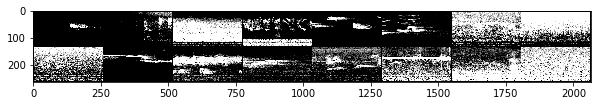

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img_grid = make_grid(bimg) 

plt.figure(figsize = (10, 10))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')

In [ ]:
import numpy

def unnormalize_img(img: torch.tensor) -> numpy.array:
  mean=0.4495
  std=0.1798

  img = img * std + mean
  img_npy = img.permute(1, 2, 0).numpy().squeeze()

  return img_npy

Img shape:  torch.Size([1, 128, 256])
min_value = -2.5, max_value = 3.0611791610717773
Label:  0

After unnormalization: 
min_value = -2.9802322387695312e-08, max_value = 0.9998999834060669
Img shape:  (128, 256)


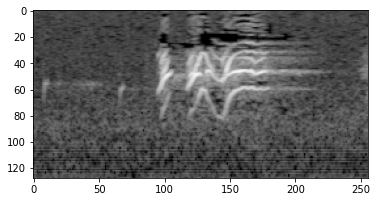

In [ ]:
import matplotlib.pyplot as plt

img, label = train_set[6]
print('Img shape: ', img.shape)
print(f'min_value = {img.min()}, max_value = {img.max()}')
print('Label: ', label)

img_npy = unnormalize_img(img)
print('\nAfter unnormalization: ')
print(f'min_value = {img_npy.min()}, max_value = {img_npy.max()}')
print('Img shape: ', img_npy.shape)
plt.imshow(img_npy, cmap='gray')

### Compute mean and std for the whole training set as representative statistics of the whole dataset

In [ ]:
from tqdm import tqdm
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for bimg, blabel in tqdm(train_loader):
    psum    += bimg.sum(axis        = [0, 2, 3])
    psum_sq += (bimg ** 2).sum(axis = [0, 2, 3])

100%|██████████| 1985/1985 [01:04<00:00, 30.54it/s]


In [ ]:
####### FINAL CALCULATIONS

# pixel count
count = len(train_set) * bimg.shape[2] * bimg.shape[3]

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([-0.0003])
std:  tensor([0.9997])


### Compute class weights to deal with dataset imbalance

In [ ]:
from tqdm import tqdm

count = torch.zeros((1,10), dtype=torch.int32)

# Count total number of occurrences of each class along the whole trainingset
for bimg, blabel in tqdm(train_loader):

    count += torch.bincount(blabel, minlength=10)

print(count)

100%|██████████| 1985/1985 [00:53<00:00, 37.42it/s]

tensor([[4890, 6642, 1444, 1759, 1035, 5122, 1385, 2186, 5443, 1854]],
       dtype=torch.int32)


In [ ]:
freq = count / count.sum()
print(freq)

tensor([[0.1540, 0.2091, 0.0455, 0.0554, 0.0326, 0.1613, 0.0436, 0.0688, 0.1714,
         0.0584]])


In [ ]:
# The weights should be inversely proportional to the frequency of occurrence of each class in the dataset, 
# so classes that have less appearance are weighted more

#  We used the following expression to compute the weights, as indicated in the paper
# {Adam Paszke, Abhishek Chaurasia, Sangpil Kim, and Eugenio Culurciello. Enet:
#  A deep neural network architecture for real-time semantic segmentation. CoRR, abs/1606.02147, 2016}

#            wn = 1 / ln(1.02 + βn)

# where βn corresponds to the frequency of occurrence of the class, and the term 1.02 is added for stability.

weights = 1 / torch.log(1.02 + freq)
print(weights)

tensor([[ 6.2348,  4.8471, 15.7698, 13.7593, 19.5114,  6.0027, 16.2161, 11.7505,
          5.7106, 13.2528]])


### CUSTOM DATASET CLASS FOR VALIDATION AND TEST

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
import os
import csv
import pandas as pd

In [ ]:
VALID_DATA_PATH = 'preprocessedData/validation/spec'
TEST_DATA_PATH = 'preprocessedData/test/spec'

In [ ]:
# open the file in the write mode
fi = open('preprocessedData/test_csv_file', 'w')
# create the csv writer
writer = csv.writer(fi)
writer.writerow(['first_image_name', 'class', 'num_specs'])

# List of classes, subfolders as class names
CLASSES = [c for c in sorted(os.listdir(TEST_DATA_PATH))]

data = []
numSpecs = 0

# Parse every class
for c_idx, c in enumerate(CLASSES):

    # List all audio files
    FILES = [f for f in sorted(os.listdir(os.path.join(TEST_DATA_PATH, c)))]

    for f_idx, f in enumerate(FILES):

        f_bird = f.split('_')[0]
        f_spec = int(f.split('_')[2][-2:])

        if f_spec == 0:
            if not data:
                data.append(FILES[f_idx])
                data.append(c_idx)
            else:     
                data.append(numSpecs)
                writer.writerow(data)

                data = []
                numSpecs = 0
                data.append(FILES[f_idx])
                data.append(c_idx)
          
        numSpecs += 1 

# close the file
fi.close()      
        

In [ ]:
df = pd.read_csv("preprocessedData/valid_csv_file")

In [ ]:
df.head()

,first_image_name,class,num_specs
0,Cardueliscarduelis179322_SpecIdx_000_SNR_0401.png,0,20
1,Cardueliscarduelis236446_SpecIdx_000_SNR_1405.png,0,20
2,Cardueliscarduelis239679_SpecIdx_000_SNR_0315.png,0,18
3,Cardueliscarduelis239684_SpecIdx_000_SNR_0012.png,0,20
4,Cardueliscarduelis243565_SpecIdx_000_SNR_0517.png,0,20


In [ ]:
df['num_specs'].sum()

3651

In [ ]:
import os
from PIL import Image

class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.CLASSES = [c for c in sorted(os.listdir(self.root_dir))]

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = []

        img_name = self.data_frame.iloc[idx,0].split('_')[0]
        label = self.data_frame.iloc[idx,1]
        num_specs = self.data_frame.iloc[idx,2]
        PATH = os.path.join(self.root_dir, CLASSES[label])

        FILES = [f for f in sorted(os.listdir(PATH)) if f.startswith(img_name)]

        for img in FILES:

          img_path = os.path.join(PATH, img)
          img = Image.open(img_path)
          img = img.convert("RGB")
          if self.transform:
              img = self.transform(img)
          
          images.append(img)

        return (images, label)

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
                               # o a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize(mean=[0.4495], # computed below
                             std=[0.1798])  # computed below
    ])


valid_set = CustomDataset(
    "preprocessedData/valid_csv_file",
    "preprocessedData/validation/spec",
    data_transform
    )

valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=1, 
    shuffle=False,
    drop_last=False,
)

test_set = CustomDataset(
    "preprocessedData/test_csv_file",
    "preprocessedData/test/spec",
    data_transform
    )

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1, 
    shuffle=False,
    drop_last=False,
)

In [ ]:
# We can retrieve a sample from the dataset by simply indexing it
images, label = valid_set[0]
print('Number of specs: ', len(images))
print('Label: ', label)
print(len(valid_set))

images, label = test_set[0]
print('Number of specs: ', len(images))
print('Label: ', label)
print(len(test_set))

Number of specs:  20
Label:  0
224
Number of specs:  20
Label:  0
221
